# Tutorial V: Deep models

<p>
Bern Winter School on Machine Learning, 28.01-01.02 2019<br>
Mykhailo Vladymyrov
</p>

This work is licensed under a <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/">Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License</a>.

In this session we will use the pretrained Inception model to build own image classifier. We will aslo learn how to save our trained models.

## unpack libraries
if using colab, upload the `material.tgz` and run the next cell

In [ ]:
!tar -xvzf material.tgz

## 1. Load necessary libraries

In [ ]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipyd
import tensorflow as tf
from PIL import Image

# We'll tell matplotlib to inline any drawn figures like so:
%matplotlib inline
plt.style.use('ggplot')
from utils import gr_disp
from utils import inception

from IPython.core.display import HTML
HTML("""<style> .rendered_html code { 
    padding: 2px 5px;
    color: #0000aa;
    background-color: #cccccc;
} </style>""")

In [ ]:
def tfSessionLimited(graph=None):
    session_config=tf.ConfigProto( gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.85))
    session_config.gpu_options.visible_device_list = str(0) #use 1st gpu
    return tf.Session(graph=graph, config=session_config)

## 2. Load the model

inception module here is a small module that performs loading the inception model as well as image preparation for the training.

In [ ]:
net, net_labels = inception.get_inception_model()

In [ ]:
#get model graph definition and change it to use GPU
gd = net

str_dg = gd.SerializeToString()
#uncomment next line to use GPU acceleration
str_dg = str_dg.replace(b'/cpu:0', b'/gpu:0') #a bit extreme approach, but works =)
gd = gd.FromString(str_dg)

#gr_disp.show(gd)

## 3. Create the graph

This whole model won't fit in GPU memory. We will take only the part from input to the main output and copy it to a second graph, that we will use further.

In [ ]:
gd2 = tf.graph_util.extract_sub_graph(gd, ['output'])
g2 = tf.Graph() # full graph
with g2.as_default():
    tf.import_graph_def(gd2, name='inception')

One can see all operations defined in the graph:

In [ ]:
gr_disp.show(g2.as_graph_def())

In [ ]:
#get names of all operation
names = [op.name for op in g2.get_operations()]
names

## 4. Build own regressor on top

We will now create a fully connected regressor the same way as in previous session. The only difference is that instead of raw image data as input we will use 2048 image features that Inceprion is trained to detect. We will classify images in 2 classes.

In [ ]:
def fully_connected_layer(x, n_output, name=None, activation=None):
    """Fully connected layer.

    Parameters
    ----------
    x : tf.Tensor
        Input tensor to connect
    n_output : int
        Number of output neurons
    name : None, optional
        TF Scope to apply
    activation : None, optional
        Non-linear activation function

    Returns
    -------
    h, W : tf.Tensor, tf.Tensor
        Output of the fully connected layer and the weight matrix
    """
    if len(x.get_shape()) != 2:
        x = flatten(x, reuse=None)

    n_input = x.get_shape().as_list()[1]

    with tf.variable_scope(name or "fc", reuse=None):
        W = tf.get_variable(
            name='W',
            shape=[n_input, n_output],
            dtype=tf.float32,
            initializer=tf.contrib.layers.xavier_initializer())

        b = tf.get_variable(
            name='b',
            shape=[n_output],
            dtype=tf.float32,
            initializer=tf.constant_initializer(0.0))

        h = tf.nn.bias_add(
            name='h',
            value=tf.matmul(x, W),
            bias=b)

        if activation:
            h = activation(h)

        return h, W

In [ ]:
with g2.as_default():
    x = g2.get_tensor_by_name('inception/input:0')
    features = g2.get_tensor_by_name('inception/head0_bottleneck/reshape:0')

    #placeholder for the true one-hot label
    Y = tf.placeholder(name='Y', dtype=tf.float32, shape=[None, 2])
        
    #one layer with 512 neurons with sigmoid activation and one with 2, softmax activation.
    L1, W1 = fully_connected_layer(features, 512, 'FC1', tf.nn.sigmoid)
    L2, W2 = fully_connected_layer(L1 , 2, 'FC2')
    Y_onehot = tf.nn.softmax(L2, name='Logits')
    Y_pred = tf.argmax(Y_onehot, axis=1, name='YPred')
    
    #cross-entropy used as a measure for qulity of each image.
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=L2, labels=Y)
    
    #mean cross_entropy - for a set of images.
    loss = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss)
    
    #Accuracy is defined as fraction of correctly recognized images.
    Y_true = tf.argmax(Y, 1)
    Correct = tf.equal(Y_true, Y_pred, name='CorrectY')
    Accuracy = tf.reduce_mean(tf.cast(Correct, dtype=tf.float32), name='Accuracy')

## 5. Dataset

The Inception network is trained on natural images: thigs we see around everyday, like sky, flowers, animals, building, cars.
It builds an hierarchy of features, to describe what it sees. 
This features can be used to train fast on different classes of objects. E.g. [here](https://www.tensorflow.org/tutorials/image_retraining) it can be retrained to distinguish flowers' species.

Here you will see that these features can be even used to detect thngs very different from natural images. Namely we will try to use it to distinguish German text from Italian. We will use 100 samples, taken from 5 German and 5 Italian books, 10 samples each.

In [ ]:
text_label = ['German', 'Italian']

In [ ]:
labels0 = []
images0 = []
labels1 = []
images1 = []

#German
for book in range(1,6):
    for sample in range(1,11):
        img = plt.imread('ML3/de/%d_%d.jpg'%(book, sample))
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        images0.append(inception.prepare_training_img(img))
        labels0.append([1,0])
for book in range(1,6):
    for sample in range(1,11):
        img = plt.imread('ML3/it/%d_%d.jpg'%(book, sample))
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        images1.append(inception.prepare_training_img(img))
        labels1.append([0,1])
        
idx = np.random.permutation(len(labels0))
labels0 = np.array(labels0)[idx]
images0 = np.array(images0)[idx]
labels1 = np.array(labels1)[idx]
images1 = np.array(images1)[idx]

Lets see a sample:

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(10,10))
img_d = inception.training_img_to_display(images0[25])
axs[0].imshow(img_d)
axs[0].grid(False)
img_d = inception.training_img_to_display(images1[25])
axs[1].imshow(img_d)
axs[1].grid(False)
plt.show()

The training is similar to what we did in the second session. The new thing here is that we will save the graph model and the graph trained parameters that we got after training.

Since Inception model is big, this will take a while, even we use GPUs (one GTX 1080Ti / user). On your laptop CPU this would probably take ~15 times longer. And we are not training the whole Inception! We have just small thing on top + a very small dataset!

In [ ]:
#We will take 80% from each for training and 20 for validation
n_half = images0.shape[0]
n_train_half = n_half*80//100
n_train = n_train_half*2

x_train = np.r_[images0[:n_train_half], images1[:n_train_half]]
y_train = np.r_[labels0[:n_train_half], labels1[:n_train_half]]

x_valid = np.r_[images0[n_train_half:], images1[n_train_half:]]
y_valid = np.r_[labels0[n_train_half:], labels1[n_train_half:]]

mini_batch_size = 10

#directory where the model will be stored
try:
    os.mkdir('Seminar3_graph')
except:
    pass

with tfSessionLimited(graph=g2) as sess:
    #initialize all the variables 
    a_tr = []
    a_vld = []
    losses_t = []
    losses_v = []

    #create saver
    saver = tf.train.Saver(tf.global_variables())
    sess.run(tf.global_variables_initializer())
    
    saver.export_meta_graph(os.path.join('Seminar3_graph', 'model.meta'))

    for epoch in range (150):
        #shuffle the data and perform stochastic gradient descent by runing over all minibatches
        idx = np.random.permutation(n_train)
        for mb in range(n_train//mini_batch_size):
            sub_idx = idx[mini_batch_size*mb:mini_batch_size*(mb+1)]
            _, l = sess.run((optimizer, loss), feed_dict={x:x_train[sub_idx], Y:y_train[sub_idx]})
            l_v = sess.run(loss, feed_dict={x:x_valid, Y:y_valid})
            losses_t.append(np.mean(l))
            losses_v.append(np.mean(l_v))

        #get accuracy on the training set and test set
        accuracy_train = sess.run(Accuracy, feed_dict={x:x_train, Y:y_train})
        accuracy_valid = sess.run(Accuracy, feed_dict={x:x_valid, Y:y_valid})
        
        #every 10th epoch print accuracies and current loss
        if epoch%10 == 0:
            print(accuracy_train, accuracy_valid, l)

        a_tr.append(accuracy_train)
        a_vld.append(accuracy_valid)
    
    #save the graph state, checkpoint ch-0
    checkpoint_prefix = os.path.join('Seminar3_graph', 'ch')
    saver.save(sess, checkpoint_prefix, global_step=0, latest_filename='ch_last')
  
plt.plot(a_tr)
plt.plot(a_vld)
plt.legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

plt.plot(losses_t)
plt.plot(losses_v)
plt.legend(('training loss','validation loss'), loc='upper right')
plt.show()

We see that training accuracy hits 100% quickly. Why do you think it happens? Consider that loss keeps decreasing.
Also on such a small dataset our model overfits.

## 6. Load trained variables

If we have the model already created we can easily load the saved training variables valueas from a checkpoint:

In [ ]:
with tfSessionLimited(graph=g2) as sess:
    #create saver and restore values
    saver = tf.train.Saver()
    saver.restore(sess, os.path.join('Seminar3_graph', 'ch-0'))
    
    #check that we still get proper performance oh a random image
    r1 = sess.run(Y_onehot, feed_dict={x:images1[:1]})
    
    print(r1)
    

## 7. Loading graph and variables. Saving constant subgraph.

Now, we don't want to define the whole model the same way we created it every time to use it. Might be you did it before a Friday apero, and then changed something.... And on Moday ... there is no way to remember! 
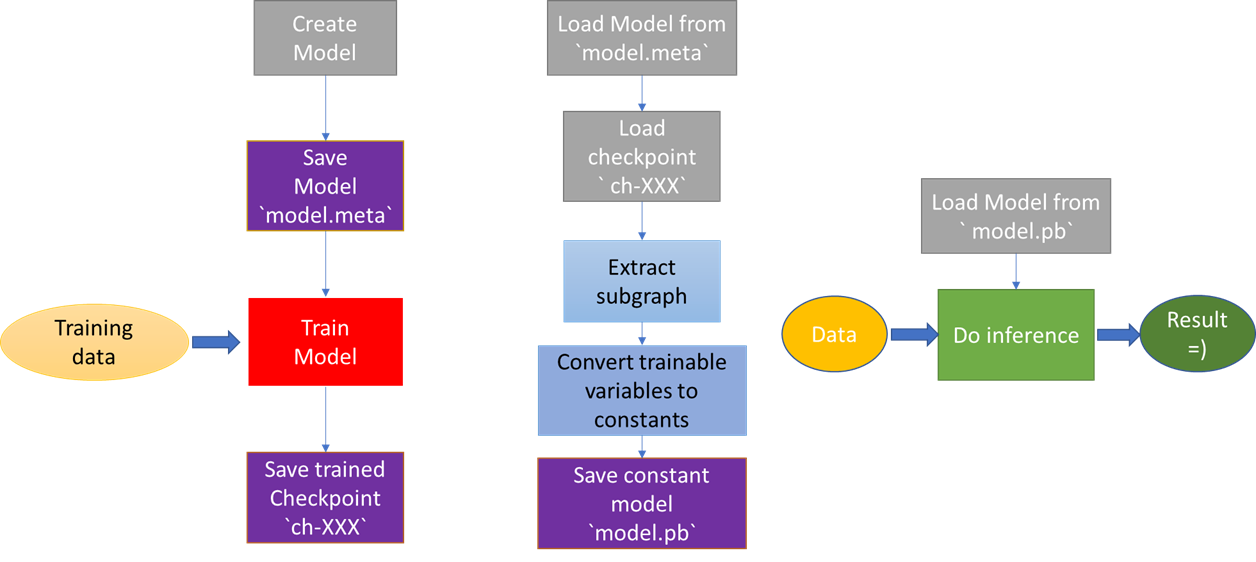

To restore model we will load the metagraph:

In [ ]:
def get_saved_graph(path):
    g = tf.Graph()
    with g.as_default():
        saver = tf.train.import_meta_graph(path)
        return g

Then, lets restore it to a new graph:

In [ ]:
g3 = get_saved_graph(os.path.join('Seminar3_graph', 'model.meta'))

In [ ]:
gr_disp.show(g3.as_graph_def())

In [ ]:
with tfSessionLimited(graph=g3) as sess:
    #create saver and restore values
    saver = tf.train.Saver()
    saver.restore(sess, os.path.join('Seminar3_graph', 'ch-0'))
    
    #check that we still get proper performance oh a random image
    x3 = g3.get_tensor_by_name('inception/input:0')
    yhot3 = g3.get_tensor_by_name('Logits:0')
    r1 = sess.run(yhot3, feed_dict={x3:images1[:1]})
    
    print(r1)

Once the model is trained you want to use it for inference. For this you convert all the variables to canstants, and obtain the `GraphDef`

In [ ]:
g3 = get_saved_graph(os.path.join('Seminar3_graph', 'model.meta'))

dst_nodes = ['Logits', 'YPred']

with tfSessionLimited(graph=g3) as sess:
    # restore variables
    saver = tf.train.Saver(tf.global_variables())
    saver.restore(sess, os.path.join('Seminar3_graph', 'ch-0'))
        
    # Now lets convert trainable parameters to constants for the 
    # inference use (dst_nodes is the list of final operations.
    # Everything on what they depend will be conveted as well)
    graph_def = tf.graph_util.convert_variables_to_constants(
        sess, g3.as_graph_def(add_shapes=True), dst_nodes)
    

Finally, we create a graph where we copy only everything needed to compute the `dst_nodes`, and export is as `const_graph.pb`

In [ ]:
with tf.Graph().as_default():
    #extract everything on what Logits and YPred depend
    sub_graph = tf.graph_util.extract_sub_graph(graph_def, dst_nodes)
    
    #save in a protobuf
    tf.train.write_graph(sub_graph, 'Seminar3_graph/', 'const_graph.pb', as_text=False)

## 8. Loading constant graph

Now you can take the `const_graph.pb`, and use for language detection elsewhere. There is trainable parameters in it: they are all converted to constants. This is what you deploy on production. You can use it in c++ version of TF.

Lets again check it. We will create one more graph, and read only this file in it:

In [ ]:
g5 = tf.Graph()
with g5.as_default():
    #read protobuf file to a graph definition
    with tf.gfile.GFile("Seminar3_graph/const_graph.pb",'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())
    
    #import graphdef into current graph (g5)
    tf.import_graph_def(graph_def, name='')
    
    #display it. Looks sooo clean now!
    gr_disp.show(graph_def)

In [ ]:
#check if it works    
with tfSessionLimited(graph=g5) as sess:
    # get input and output tensors, and run it for one image:
    x5 = g5.get_tensor_by_name("inception/input:0")
    y5 = g5.get_tensor_by_name("Logits:0")
    p5 = g5.get_tensor_by_name("YPred:0")
    r5,rp5 = sess.run([y5,p5], feed_dict={x5:images1[:1]})
    
    print(r5, rp5)

## 9. Improving the results

Often, as in this sample we don't have anough labeled data in hand. We need to use it as efficient as possible.
One way to do it is to aply training data augmentation: we can slightly distort it, e.g. rescale, to effectively multiply the dataset.

We will generate rescaled images, minimum - to have smaller dimension equal 256, maximum - 130%. Let's define a function which will do this job:

In [ ]:
def get_random_scaled_img(file, minsize = 256, scalemax=1.3):
    im = Image.open(file)
    w, h = im.size
    # get minimal possible size
    scalemin =float(minsize) / min(w,h)
    # get a rescale factor from a uniform distribution.
    scale = scalemin + np.random.rand() * (scalemax - scalemin)
    w1 = int(max(minsize, scale*w))
    h1 = int(max(minsize, scale*h))
    
    #rescale with smoothing
    im1 = im.resize((w1,h1), Image.ANTIALIAS)
    #get numpy array from the PIL Image
    img_arr = np.array(im1.convert('RGB'))

    #crop to 256x256, preventing further resize by prepare_training_img
    r = (img_arr.shape[0] - minsize) // 2
    c = (img_arr.shape[1] - minsize) // 2
    img_arr = img_arr[r:r+minsize,c:c+minsize]

    return img_arr

Lets check rescaled images.

In [ ]:
n_smpl=2
scaled_imgs=[get_random_scaled_img('ML3/de/%d_%d.jpg'%(1, 1)) for i in range(n_smpl**2)]
fig, ax = plt.subplots(n_smpl, n_smpl, figsize=(n_smpl*4, n_smpl*4))
for row in range(n_smpl):
    for col in range(n_smpl):
        ax[col, row].imshow(scaled_imgs[row*n_smpl+col])
        ax[col, row].grid(False)

Read again images, now generating 5 rescaled from each one.

We can test three different ways of splitting in training and validation datasets:
1. randomize order of all rescaled elements from all samples from all books, then split T/V
2. randomize order of all samples from all books, split in T/V, generate rescaled
3. randomize order of books, split in T/V, generate rescaled for all samples.

In 1. rescaled elements originating form same original sample will end up in both test and validation dataset, compromising  validation procedure (VERY BAD!!!).

In 2. samples from the same book will end up in both test and validation dataset. We will measure generalization to new image samples, but not to the new books/fonts (not great).

In 3. we can measure generalization to the new books/fonts, yet we exclude 1/5 of font diversity from the training set (proper validation procedure, worse actual performance).

In [ ]:
# 1
labels0 = []
images0 = []
labels1 = []
images1 = []

mult = 5
#German
for book in range(1,6):
    for sample in range(1,11):
        for itr in range(mult):
            img = get_random_scaled_img('ML3/de/%d_%d.jpg'%(book, sample))
            assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
            images0.append(inception.prepare_training_img(img))
            labels0.append([1,0])
#Italian
for book in range(1,6):
    for sample in range(1,11):
        for itr in range(mult):
            img = get_random_scaled_img('ML3/it/%d_%d.jpg'%(book, sample))
            assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
            images1.append(inception.prepare_training_img(img))
            labels1.append([0,1])
        
idx = np.random.permutation(len(labels0))
labels0 = np.array(labels0)[idx]
images0 = np.array(images0)[idx]
labels1 = np.array(labels1)[idx]
images1 = np.array(images1)[idx]

n_half = images0.shape[0]
n_train_half = n_half*80//100

x_train_all_mixed = np.concatenate([images0[:n_train_half], images1[:n_train_half]])
y_train_all_mixed = np.concatenate([labels0[:n_train_half], labels1[:n_train_half]])

x_valid_all_mixed = np.concatenate([images0[n_train_half:], images1[n_train_half:]])
y_valid_all_mixed = np.concatenate([labels0[n_train_half:], labels1[n_train_half:]])

In [ ]:
# 2
labels0 = []
images0 = []
labels1 = []
images1 = []

mult = 5
# German

# get all originanal samples
all_samples_path_de = []
for book in range(1,6):
    for sample in range(1,11):
        all_samples_path_de.append('ML3/de/%d_%d.jpg'%(book, sample))
        
# shuffle all original samples
all_samples_path_de = np.array(all_samples_path_de)
idx = np.random.permutation(len(all_samples_path_de))
all_samples_path_de = all_samples_path_de[idx]

#multiply them
for path in all_samples_path_de:
    for itr in range(mult):
        img = get_random_scaled_img(path)
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        images0.append(inception.prepare_training_img(img))
        labels0.append([1,0])

        
# same for Italian
all_samples_path_it = []
for book in range(1,6):
    for sample in range(1,11):
        all_samples_path_it.append('ML3/it/%d_%d.jpg'%(book, sample))
        
# shuffle all original samples
all_samples_path_it = np.array(all_samples_path_it)
idx = np.random.permutation(len(all_samples_path_it))
all_samples_path_it = all_samples_path_it[idx]

#multiply them
for path in all_samples_path_it:
    for itr in range(mult):
        img = get_random_scaled_img(path)
        assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
        images1.append(inception.prepare_training_img(img))
        labels1.append([0,1])
        
        
# here we don't shuffle, they are shuffled already
labels0 = np.array(labels0)
images0 = np.array(images0)
labels1 = np.array(labels1)
images1 = np.array(images1)

n_half = images0.shape[0]
n_train_half = n_half*80//100

x_train_smpl_mixed = np.concatenate([images0[:n_train_half], images1[:n_train_half]])
y_train_smpl_mixed = np.concatenate([labels0[:n_train_half], labels1[:n_train_half]])

x_valid_smpl_mixed = np.concatenate([images0[n_train_half:], images1[n_train_half:]])
y_valid_smpl_mixed = np.concatenate([labels0[n_train_half:], labels1[n_train_half:]])

In [ ]:
# 3
labels0 = []
images0 = []
labels1 = []
images1 = []

mult = 5
# German

# get all books samples
all_books_ids = np.random.permutation(5) + 1
for book in all_books_ids:
    for sample in range(1,11):
        for itr in range(mult):
            img = get_random_scaled_img('ML3/de/%d_%d.jpg'%(book, sample))
            assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
            images0.append(inception.prepare_training_img(img))
            labels0.append([1,0])
#Italian
all_books_ids = np.random.permutation(5) + 1
for book in all_books_ids:
    for sample in range(1,11):
        for itr in range(mult):
            img = get_random_scaled_img('ML3/it/%d_%d.jpg'%(book, sample))
            assert(img.shape[0]>=256 and img.shape[1]>=256 and len(img.shape)==3)
            images1.append(inception.prepare_training_img(img))
            labels1.append([0,1])
        
# here we don't shuffle, they are shuffled already
labels0 = np.array(labels0)
images0 = np.array(images0)
labels1 = np.array(labels1)
images1 = np.array(images1)

n_half = images0.shape[0]
n_train_half = n_half*80//100

x_train_books_mixed = np.concatenate([images0[:n_train_half], images1[:n_train_half]])
y_train_books_mixed = np.concatenate([labels0[:n_train_half], labels1[:n_train_half]])

x_valid_books_mixed = np.concatenate([images0[n_train_half:], images1[n_train_half:]])
y_valid_books_mixed = np.concatenate([labels0[n_train_half:], labels1[n_train_half:]])

In [ ]:
def get_train_valid_samples(split_type = 1):
    """ selects training and validation dataset according to the requested split type.

    Parameters
    ----------
    split_type : int
        1 - shuffle all, 2 - shuffle samples, but not rescaled, 3 - shuffle books only

    Returns
    -------
    x_train, y_train, x_valid, y_valid: np.ndarray, np.ndarray, np.ndarray, np.ndarray
        datasets
    """
    
    idx = split_type - 1  # split_type starts from 1, index - from 0
    x_t = [x_train_all_mixed, x_train_smpl_mixed, x_train_books_mixed]
    y_t = [y_train_all_mixed, y_train_smpl_mixed, y_train_books_mixed]
    
    x_v = [x_valid_all_mixed, x_valid_smpl_mixed, x_valid_books_mixed]
    y_v = [y_valid_all_mixed, y_valid_smpl_mixed, y_valid_books_mixed]

    return x_t[idx], y_t[idx], x_v[idx], y_v[idx]

And finally do training again, same way. Just now we change the number of epochs: before we had 150, but now that we have 5 times more training data we'll do 60. While 60 > 150/5, it looks like it takes a bit more time to converge.
We use the same graph as before, `g2`, the one we can train.

In [ ]:
split_type = 3 # 1 - shuffle all, 2 - shuffle samples, but not rescaled, 3 - shuffle books only
x_train, y_train, x_valid, y_valid = get_train_valid_samples(split_type)
n_train = x_train.shape[0]

a_tr = []
a_vld = []
mini_batch_size = 10


with tfSessionLimited(graph=g2) as sess:
    #initialize all the variables 
    a_tr = []
    a_vld = []
    losses_t = []
    losses_v = []

    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())

    for epoch in range (60):
        #shuffle the data and perform stochastic gradient descent by runing over all minibatches
        idx = np.random.permutation(n_train)
        for mb in range(n_train//mini_batch_size):
            sub_idx = idx[mini_batch_size*mb:mini_batch_size*(mb+1)]
            _, l = sess.run((optimizer, loss), feed_dict={x:x_train[sub_idx], Y:y_train[sub_idx]})
            l_v = sess.run(loss, feed_dict={x:x_valid, Y:y_valid})
            losses_t.append(np.mean(l))
            losses_v.append(np.mean(l_v))

        accuracy_train = sess.run(Accuracy, feed_dict={x:x_train, Y:y_train})
        accuracy_valid = sess.run(Accuracy, feed_dict={x:x_valid, Y:y_valid})
        if epoch%5 == 0:
            print(accuracy_train, accuracy_valid, l, l_v)
        a_tr.append(accuracy_train)
        a_vld.append(accuracy_valid)
        
    #save the graph state, checkpoint ch-1
    checkpoint_prefix = os.path.join('Seminar3_graph', 'ch')
    saver.save(sess, checkpoint_prefix, global_step=1, latest_filename='ch_last')
    
plt.plot(a_tr)
plt.plot(a_vld)
plt.legend(('training accuracy', 'validation accuracy'), loc='lower right')
plt.show()

plt.plot(losses_t)
plt.plot(losses_v)
plt.legend(('training loss','validation loss'), loc='upper right')
plt.show()

Example of performance depending on splitting (may vary from run to run):
<table>
    <tr >
        <th style="text-align: center;">1. shuffle all</th>
        <th style="text-align: center;">2. shuffle book samples</th>
        <th style="text-align: center;">3. shuffle books</th>
    </tr>
    <tr>
        <td> 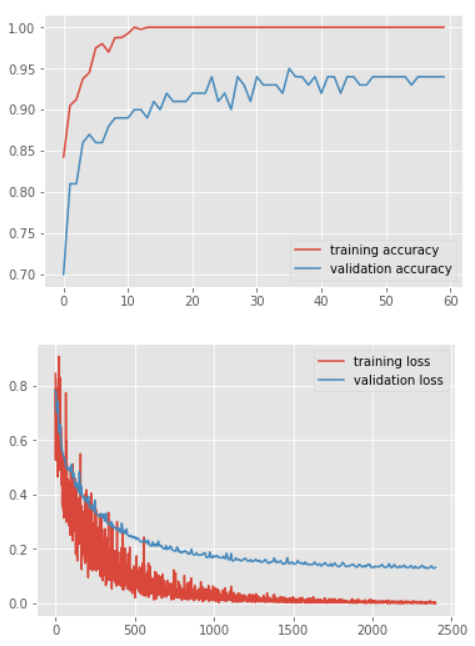</td>
        <td> 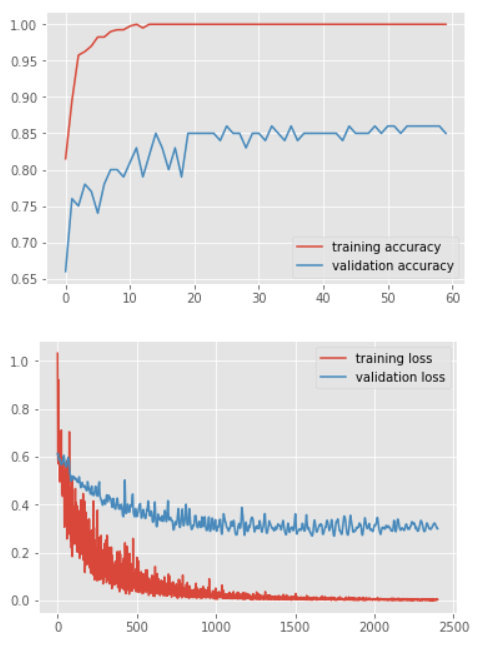</td>
        <td> 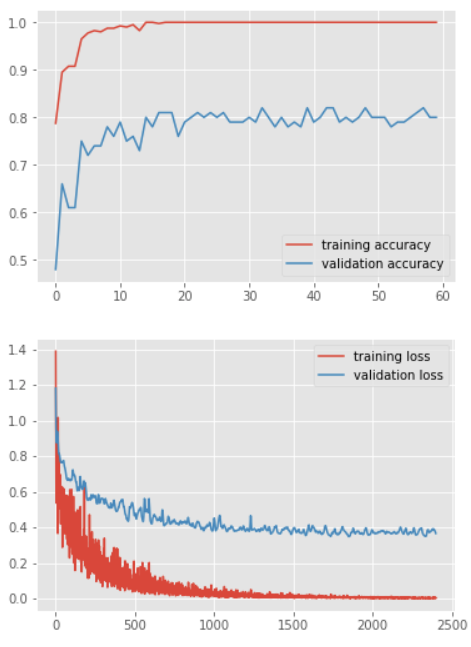</td>
    </tr>
</table>

As expected the validation accuracy is less when we split properly, reflecting the true generalization performance.
Also, in split 1. the loss still goes down in the end of training, sugesting that we can train longer. Yet, this is again due to overlap between the training and validation sets.

We had a REEEALLY small dataset for such a complicated task. Does it really generalize? mb it just memorizes all the images we fed into it? Lets perform a test. `w1.PNG` and `w2.PNG` are text screenshots from wikipedia in [Italian](https://it.wikipedia.org/wiki/Apprendimento_automatico) and [German](https://de.wikipedia.org/wiki/Maschinelles_Lernen).

In [ ]:
# load images
im_wiki_1 = plt.imread('ML3/w1.jpg')
im_wiki_2 = plt.imread('ML3/w2.jpg')

# crop/covert for proper color range
im_wiki_1_p = inception.prepare_training_img(im_wiki_1)[np.newaxis]
im_wiki_2_p = inception.prepare_training_img(im_wiki_2)[np.newaxis]

with tfSessionLimited(graph=g2) as sess:
    saver = tf.train.Saver()
    # load checkpoint after the last training
    saver.restore(sess, os.path.join('Seminar3_graph', 'ch-1'))
        
    # get predictions
    pred1 = sess.run(Y_onehot, feed_dict={x:im_wiki_1_p})
    pred2 = sess.run(Y_onehot, feed_dict={x:im_wiki_2_p})

    # will it be ok???
    print('probabilities for w1:', pred1, 'detected language:', text_label[np.argmax(pred1)])
    print('probabilities for w2:', pred2, 'detected language:', text_label[np.argmax(pred2)])

    # Show image crops
    plt.imshow( inception.training_img_to_display(im_wiki_1_p[0]))
    plt.show()
    plt.imshow( inception.training_img_to_display(im_wiki_2_p[0]))
    plt.show()

As you see it works. Probabilities are close to 100%, meaning the net is confident that it's theese languages, it's not just a random fluctuation around 50% margin.

## 12. Excercise 1

In the above example is a serius problem: the training and validation datasets are not independent. We generated 5 randomly scaled images from each initial image. With high probability from 5 images (generated from same initial one!) some will end up im the training and some in validation datasets. Since they are generated from the same initial ones, they are not fully independent. This compromises evaluation of model performance, leading to overestimate of the performance.

1. Modify the generation of the training and validation datasets to fulfil requirenment of independance.
2. Check how validation accuracy and loss changes

## 13. Excercise 2

(Hope we have time left....)
Test the performance of model trained on NOT rescaled images, on the wiki screenshots.

In [ ]:
#copy the above code here
#load the checkpoint ch-0 instead of ch-1


....

## 14. Homework (3 options)

### 14.1 Improve training set

So far we scaled images as a whole. 
- Try to scale differently in $x$ and $y$ direction.
- Check how it affects performace.
- Which else transformation would make sence for the text data?
- Get hands dirty.

### 14.2 Try to use lower layers' outputs from Inception to build the classifier.

So far we used last output of Inception.
- Look at the Inception more carefully.
- Inspect the size of the data array at different layers.
- Since inside you have 3D data (2D image * features at each position) you will need to flatten it. Look how this is done in last layers (`head0`).
- Ask, google it, and get your hands dirty!

### 14.3 Classify 3 languages.

So far we tried two languages.
- Create 50 crops of text in another language (better use 5 sources with different fonts, otherwise you risk to learn font, not language), images size > 300 x 300 (to allow scaling).
- Upload them to the `ML3` directory inside of a new directory `xx`.
- Repeat everything with 3 classes.
- Think of the case when this approach won't work.
- Get hands dirty!!!